# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ast import literal_eval
import pingouin as pg

# Utils

In [2]:
def get_zscore(s):
    return (s - s.mean()) / s.std()

def zscore_by_condition(data, metric, conditions):
    condition_df_list = []
    for group_name, group_df in data.groupby(by=conditions):
        group_df[f'z_{metric}'] = get_zscore(group_df[metric]).apply(abs)
        condition_df_list.append(group_df)

    df = pd.concat(condition_df_list)
    return df


In [3]:
def add_stat_annotation(ax, data, x, y, hue, p_col, posthoc_df, **kwargs):
    """
    Ajoute des annotations sur les boxplots pour indiquer les différences significatives.
    """
    factor_1 = data[x].unique()
    factor_2 = data[hue].unique()

    box_coords = {}
    for line in ax.get_lines():
        # print(line)
        if line.get_linestyle() == 'None':  # Les points sont les médianes
            x_line, y_line = line.get_xdata(), line.get_ydata()
            if len(x_line)>0 and len(y_line)>0:
                for x in x_line:
                    print((ax.get_xticklabels()[x].get_text(), ax.get_legend().get_texts()))
                # print(x_line, y_line)
                # print((ax.get_xticklabels()[int(x_line[0])].get_text(), ax.get_legend().get_texts()[int((len(factor_2)-1)/2)].get_text()))
                # print(x_line[0], y_line[1])
                # box_coords[(ax.get_xticklabels()[int(x_line[0])].get_text(), ax.get_legend().get_texts()[int((len(factor_2)-1)/2)].get_text())] = (x_line[0], y_line[1])
            
    for _, row in posthoc_df.iterrows():
        group1, group2, pval = row['A'], row['B'], row[p_col]
        if pval < 0.05:
            x1, x2 = group1, group2
            y, h, col = data[y].max() + 1, 1, 'k'
            print(box_coords)
            x1_coord = box_coords[(x1, hue)]
            x2_coord = box_coords[(x2, hue)]
            ax.plot([x1_coord[0], x1_coord[0], x2_coord[0], x2_coord[0]], [x1_coord[1], y, y, x2_coord[1]], lw=1.5, c=col)
            ax.text((x1_coord[0] + x2_coord[0]) * .5, y, f"p={pval:.3e}", ha='center', va='bottom', color=col)

# Params

In [4]:
data_dir = 'data'

# Conditions overview

## Training

In [5]:
all_training = []
for subject_dir in os.listdir(data_dir):
    df = pd.read_csv(f"{data_dir}\\{subject_dir}\\conditions_sternberg_training.csv")
    all_training.append(df)

all_training_df = pd.concat(all_training)
all_training_df = all_training_df.reset_index()

all_training_df

,index,sequence,is_true,target,condition,stimuli,block,is_block_beginning,is_block_ending,sequence_fnames,target_fname,subject
0,0,"['H', 'W']",True,H,2,letter,1,True,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,0
1,1,"['R', 'G']",True,G,2,letter,1,False,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,0
2,2,"['L', 'B']",False,J,2,letter,1,False,True,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,0
3,3,"['F', 'R', 'J', 'V']",False,W,4,letter,1,True,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,0
4,4,"['Q', 'H', 'P', 'B']",True,H,4,letter,1,False,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
427,13,"['L_Arm_Z_Back', 'L_Arm_X_Back', 'R_Torso_Z_Ba...",True,R_Torso_Z_Back,4,robot,1,False,False,"['robot_stimuli\\L_Arm_Z_Back.mp4', 'robot_sti...",robot_stimuli\R_Torso_Z_Back.mp4,9
428,14,"['L_Arm_Y_For', 'L_Torso_X_Back', 'L_Head_Y_Ba...",True,L_Torso_X_Back,4,robot,1,False,True,"['robot_stimuli\\L_Arm_Y_For.mp4', 'robot_stim...",robot_stimuli\L_Torso_X_Back.mp4,9
429,15,"['L_Arm_X_Back', 'R_Head_Y_Back', 'L_Base_X_Ba...",True,R_Arm_Y_Back,6,robot,1,True,False,"['robot_stimuli\\L_Arm_X_Back.mp4', 'robot_sti...",robot_stimuli\R_Arm_Y_Back.mp4,9
430,16,"['R_Torso_Z_For', 'R_Torso_X_For', 'L_Torso_X_...",True,L_Torso_Y_For,6,robot,1,False,False,"['robot_stimuli\\R_Torso_Z_For.mp4', 'robot_st...",robot_stimuli\L_Torso_Y_For.mp4,9


9 trials for each of the 2 stimuli


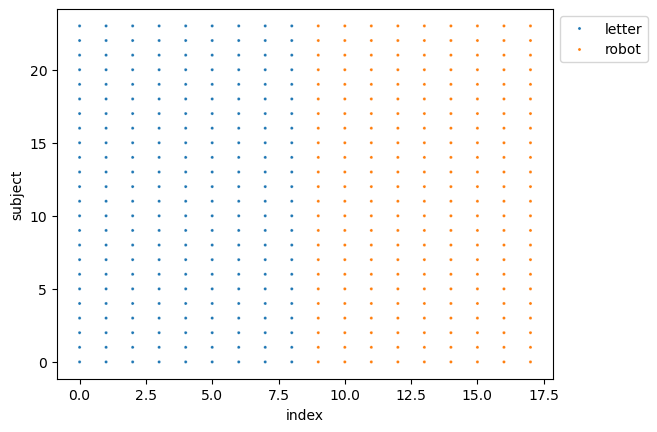

In [4]:
fig, ax = plt.subplots()
sns.scatterplot(data=all_training_df, x='index', y='subject', hue='stimuli', s=5, ax=ax)
ax.legend(bbox_to_anchor=(1,1))

print(f"{int(len(all_training_df['index'].unique())/len(all_training_df['stimuli'].unique()))} trials for each of the {len(all_training_df['stimuli'].unique())} stimuli")
plt.show()

6 blocks of 3 trials in total


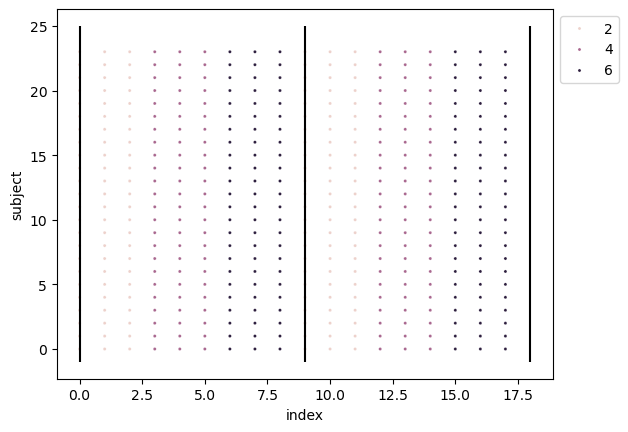

In [5]:
fig, ax = plt.subplots()

n_condition = len(all_training_df['condition'].unique())
n_trials = len(all_training_df['index'].unique())
n_blocks = len(all_training_df['block'].unique())
n_subjects = len(all_training_df['subject'].unique())

sns.scatterplot(data=all_training_df, x='index', y='subject', hue='condition', s=5, ax=ax)
ax.vlines(list(range(0, n_trials+1, int(n_trials/n_blocks))), -1, n_subjects+1, color='black')
ax.legend(bbox_to_anchor=(1,1))

print(f"{n_blocks*n_condition} blocks of {int(n_trials/(n_blocks*n_condition))} trials in total")
plt.show()

## Main

In [6]:
all_conditions = []
for subject_dir in os.listdir(data_dir):
    
    df = pd.read_csv(f"{data_dir}\\{subject_dir}\\conditions_sternberg.csv")
    all_conditions.append(df)

all_conditions_df = pd.concat(all_conditions)
all_conditions_df = all_conditions_df.reset_index()

all_conditions_df

,index,sequence,is_true,target,condition,stimuli,block,is_block_beginning,is_block_ending,sequence_fnames,target_fname,subject
0,0,"['C', 'P', 'V', 'T', 'R', 'H']",False,Q,6,letter,1,True,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,0
1,1,"['T', 'F', 'Q', 'G', 'L', 'M']",True,G,6,letter,1,False,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,0
2,2,"['T', 'F', 'Q', 'C', 'M', 'S']",True,C,6,letter,1,False,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,0
3,3,"['S', 'L', 'N', 'J', 'V', 'G']",False,C,6,letter,1,False,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,0
4,4,"['C', 'T', 'D', 'R', 'Q', 'F']",True,C,6,letter,1,False,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4315,175,"['G', 'H', 'K', 'P']",False,Q,4,letter,6,False,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,9
4316,176,"['W', 'Z', 'X', 'B']",False,J,4,letter,6,False,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,9
4317,177,"['P', 'B', 'Q', 'K']",True,Q,4,letter,6,False,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,9
4318,178,"['B', 'V', 'T', 'L']",False,D,4,letter,6,False,False,"['robot_stimuli\\\\filler.mp4', 'robot_stimuli...",robot_stimuli\\filler.mp4,9


90 trials for each of the 2 stimuli


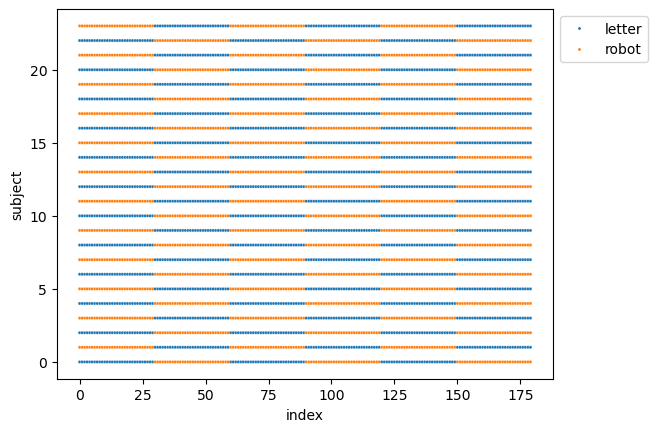

In [7]:
fig, ax = plt.subplots()
sns.scatterplot(data=all_conditions_df, x='index', y='subject', hue='stimuli', s=5, ax=ax)
ax.legend(bbox_to_anchor=(1,1))

print(f"{int(len(all_conditions_df['index'].unique())/len(all_conditions_df['stimuli'].unique()))} trials for each of the {len(all_conditions_df['stimuli'].unique())} stimuli")
plt.show()

18 blocks of 10 trials in total


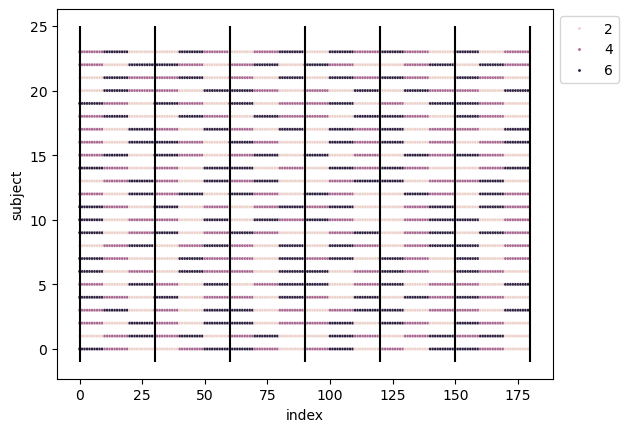

In [8]:
fig, ax = plt.subplots()

n_condition = len(all_conditions_df['condition'].unique())
n_trials = len(all_conditions_df['index'].unique())
n_blocks = len(all_conditions_df['block'].unique())
n_subjects = len(all_conditions_df['subject'].unique())

sns.scatterplot(data=all_conditions_df, x='index', y='subject', hue='condition', s=5, ax=ax)
ax.vlines(list(range(0, n_trials+1, int(n_trials/n_blocks))), -1, n_subjects+1, color='black')
ax.legend(bbox_to_anchor=(1,1))

print(f"{n_blocks*n_condition} blocks of {int(n_trials/(n_blocks*n_condition))} trials in total")
plt.show()

# Subjects

## Loading

In [127]:
all_results = []
all_match = []
for subject_dir in os.listdir(data_dir):
    result_fnames = [elem for elem in os.listdir(f'data\\{subject_dir}') if elem.split('_')[0]==subject_dir.split('_')[-1] and elem.split('.')[-1]=='csv']

    if len(result_fnames)>0:
        result_fname = result_fnames[-1]
        df = pd.read_csv(f"{data_dir}\\{subject_dir}\\{result_fname}")
        df = df[df['sequence'].apply(lambda x : isinstance(x,str))]
        df['is_training'] = df['training.thisTrialN'].notna()
        all_results.append(df)
        all_match.append(subject_dir)

print(f'Get results from {all_match}')

if len(all_match)>0:
    all_result_df = pd.concat(all_results).reset_index(drop=True)
    loaded_subjects = all_result_df['subject'].unique()

Get results from ['subject_0', 'subject_1', 'subject_10', 'subject_11', 'subject_12', 'subject_13', 'subject_14', 'subject_15', 'subject_16', 'subject_17', 'subject_18', 'subject_19', 'subject_2', 'subject_20', 'subject_21', 'subject_22', 'subject_23', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9']


## Main results

In [128]:
main_result_df = all_result_df[all_result_df['is_training']==False]

column_of_interest = ['sequence', 'is_true', 'target', 'condition', 'stimuli', 'block', 'subject', 'is_training', 'trials.thisTrialN', 'recall_key.keys', 'recall_key.rt', 'RSME_ticks.response']
main_result_df = main_result_df[column_of_interest].rename(columns={'trials.thisTrialN':'trial_n', 'recall_key.keys':'keys', 'recall_key.rt':'rt', 'RSME_ticks.response':'rsme'})
main_result_df[['condition','block','subject','trial_n']] = main_result_df[['condition','block','subject','trial_n']].astype(int)
main_result_df['sequence'] == main_result_df['sequence'].apply(literal_eval)

def get_confusion(x):
    answer, is_target = x['keys'], x['is_true']

    if answer=='None':
        return 'miss'
    elif (answer,is_target) == ('c', True): #c pressed + is_true
        return 'tp'
    elif (answer,is_target) == ('n', False): #n pressed + not is_true
        return 'tn'
    elif (answer,is_target) == ('n', True): #n pressed + is_true
        return 'fn'
    elif (answer,is_target) == ('c', False): #c pressed + not is_true
        return 'fp'

main_result_df['confusion'] = main_result_df.apply(get_confusion,axis=1)

main_result_df

,sequence,is_true,target,condition,stimuli,block,subject,is_training,trial_n,keys,rt,rsme,confusion
18,"['C', 'P', 'V', 'T', 'R', 'H']",False,Q,6,letter,1,0,False,0,n,1.117961,NaN,tn
19,"['T', 'F', 'Q', 'G', 'L', 'M']",True,G,6,letter,1,0,False,1,c,0.944512,NaN,tp
20,"['T', 'F', 'Q', 'C', 'M', 'S']",True,C,6,letter,1,0,False,2,c,1.522398,NaN,tp
21,"['S', 'L', 'N', 'J', 'V', 'G']",False,C,6,letter,1,0,False,3,n,2.042702,NaN,tn
22,"['C', 'T', 'D', 'R', 'Q', 'F']",True,C,6,letter,1,0,False,4,c,1.548754,NaN,tp
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,"['G', 'H', 'K', 'P']",False,Q,4,letter,6,9,False,175,n,0.748869,NaN,tn
4748,"['W', 'Z', 'X', 'B']",False,J,4,letter,6,9,False,176,n,0.894984,NaN,tn
4749,"['P', 'B', 'Q', 'K']",True,Q,4,letter,6,9,False,177,c,0.670664,NaN,tp
4750,"['B', 'V', 'T', 'L']",False,D,4,letter,6,9,False,178,n,1.294174,NaN,tn


## Accuracy

In [112]:
iv = ['subject','stimuli','condition']
dv = 'confusion'

melted_accuracy_df = main_result_df.groupby(by=iv, as_index=False)[dv].value_counts()

accuracy_df = melted_accuracy_df.pivot(columns='confusion', index=iv).fillna(0).astype(int)
accuracy_df.columns = [elem[1] for elem in accuracy_df.columns]

accuracy_df = accuracy_df.reset_index()
accuracy_df

,subject,stimuli,condition,fn,fp,tn,tp
0,0,letter,2,0,0,15,15
1,0,letter,4,0,0,15,15
2,0,letter,6,0,0,15,15
3,0,robot,2,1,0,15,14
4,0,robot,4,2,2,13,13
...,...,...,...,...,...,...,...
139,23,letter,4,0,1,14,15
140,23,letter,6,1,1,14,14
141,23,robot,2,0,0,15,15
142,23,robot,4,1,1,14,14


In [113]:
order = ['tn', 'tp', 'fp', 'fn']
melted_accuracy_df['confusion'] = pd.Categorical(melted_accuracy_df['confusion'], categories=order)

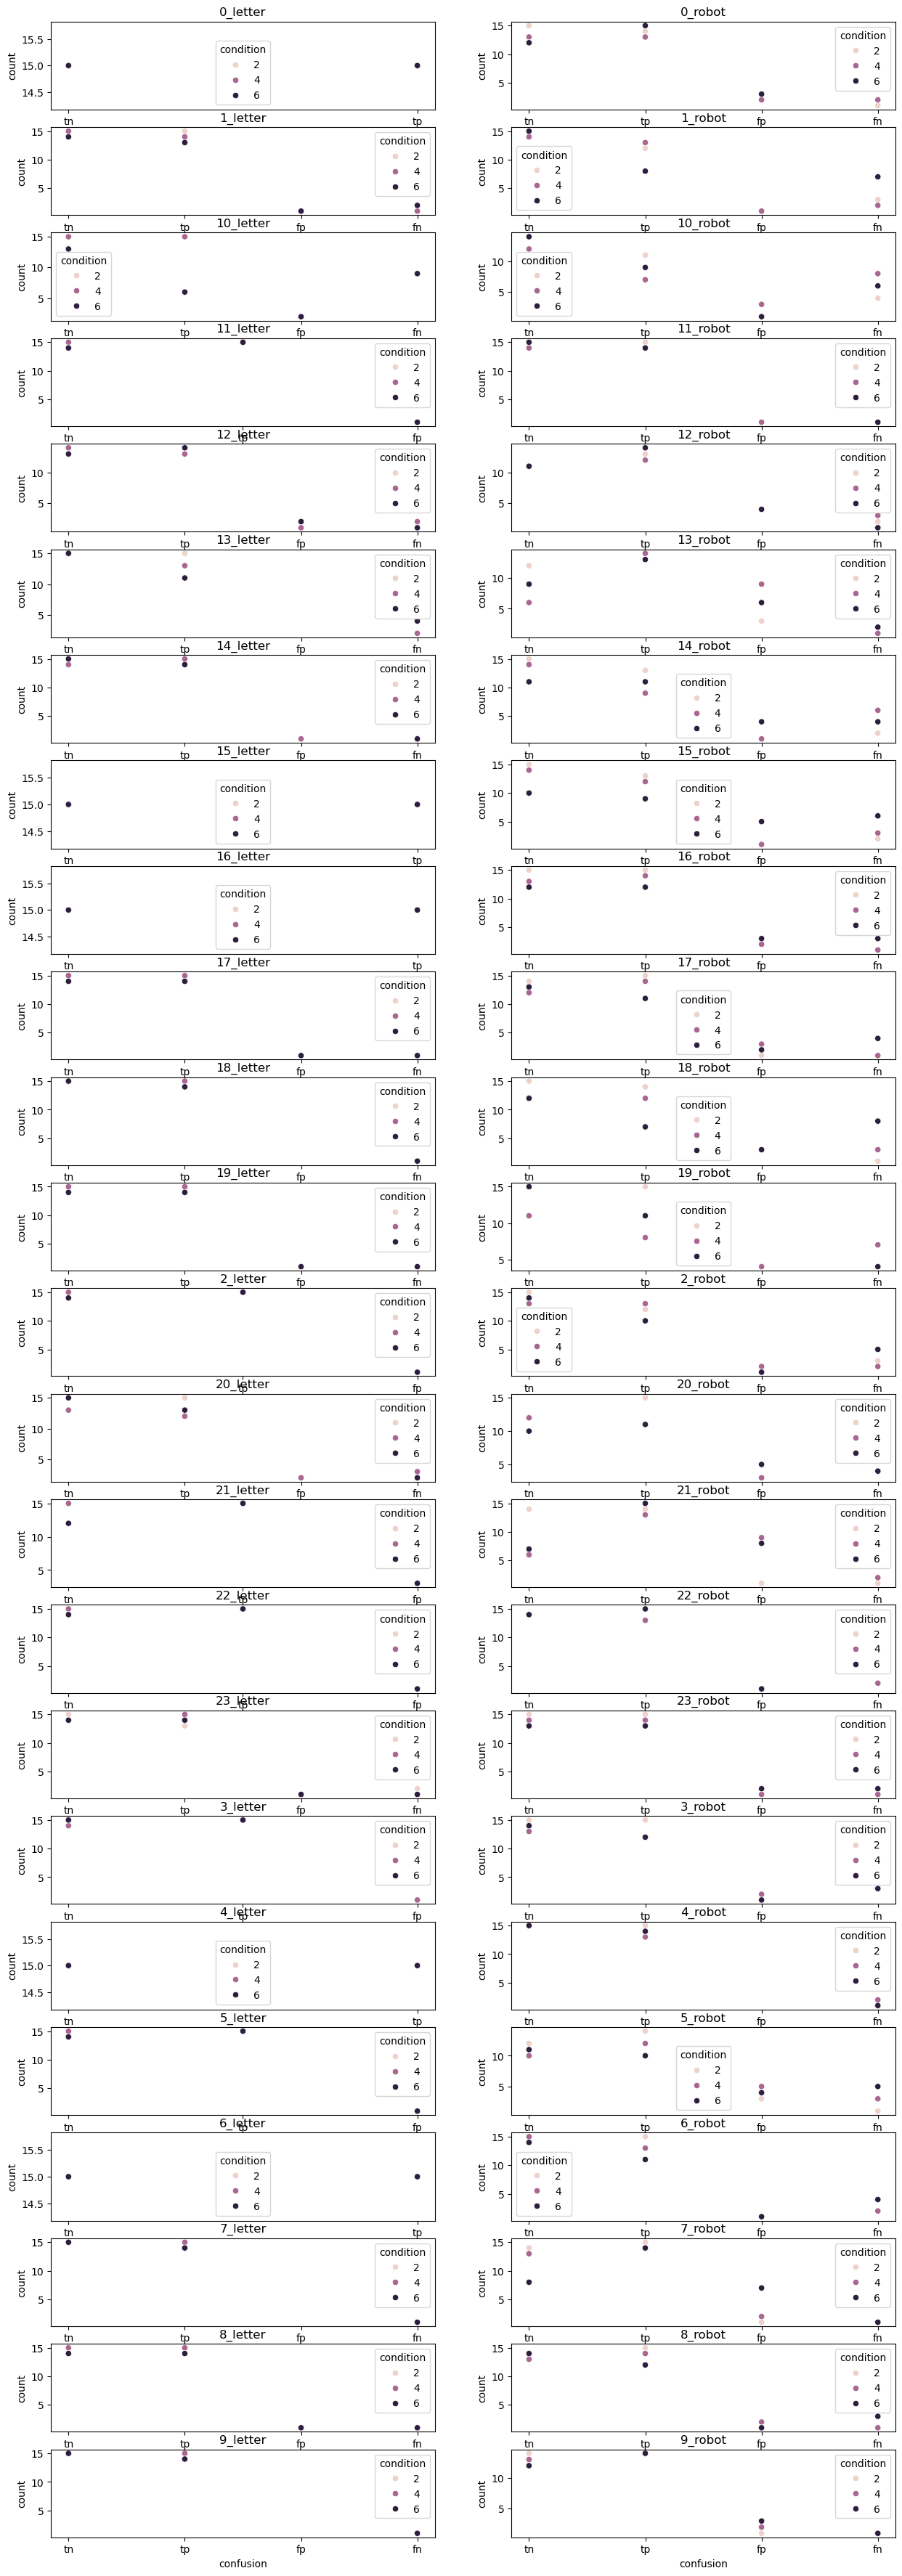

In [114]:
fig, axs = plt.subplots(len(main_result_df['subject'].unique()),2, figsize = (15,45))

for j, subject in enumerate(main_result_df['subject'].unique()):
    subject_df = melted_accuracy_df[melted_accuracy_df['subject']==subject]
    for i, stimuli in enumerate(['letter', 'robot']):
        ax = axs[j, i]
        plot_df = subject_df[subject_df['stimuli']==stimuli]
        sns.scatterplot(data=plot_df, x='confusion', y='count', hue='condition', ax=ax)
        ax.set_title(f'{subject}_{stimuli}')

plt.show()

## Response Time

In [14]:
iv = ['subject','stimuli','condition']
dv = 'rt'

rt_df = main_result_df.groupby(by=iv, as_index=False)[dv].mean()

rt_df

,subject,stimuli,condition,rt
0,0,letter,2,1.180487
1,0,letter,4,1.469782
2,0,letter,6,1.798378
3,0,robot,2,2.835180
4,0,robot,4,3.272654
...,...,...,...,...
103,17,letter,4,0.656854
104,17,letter,6,0.757412
105,17,robot,2,1.983495
106,17,robot,4,2.476761


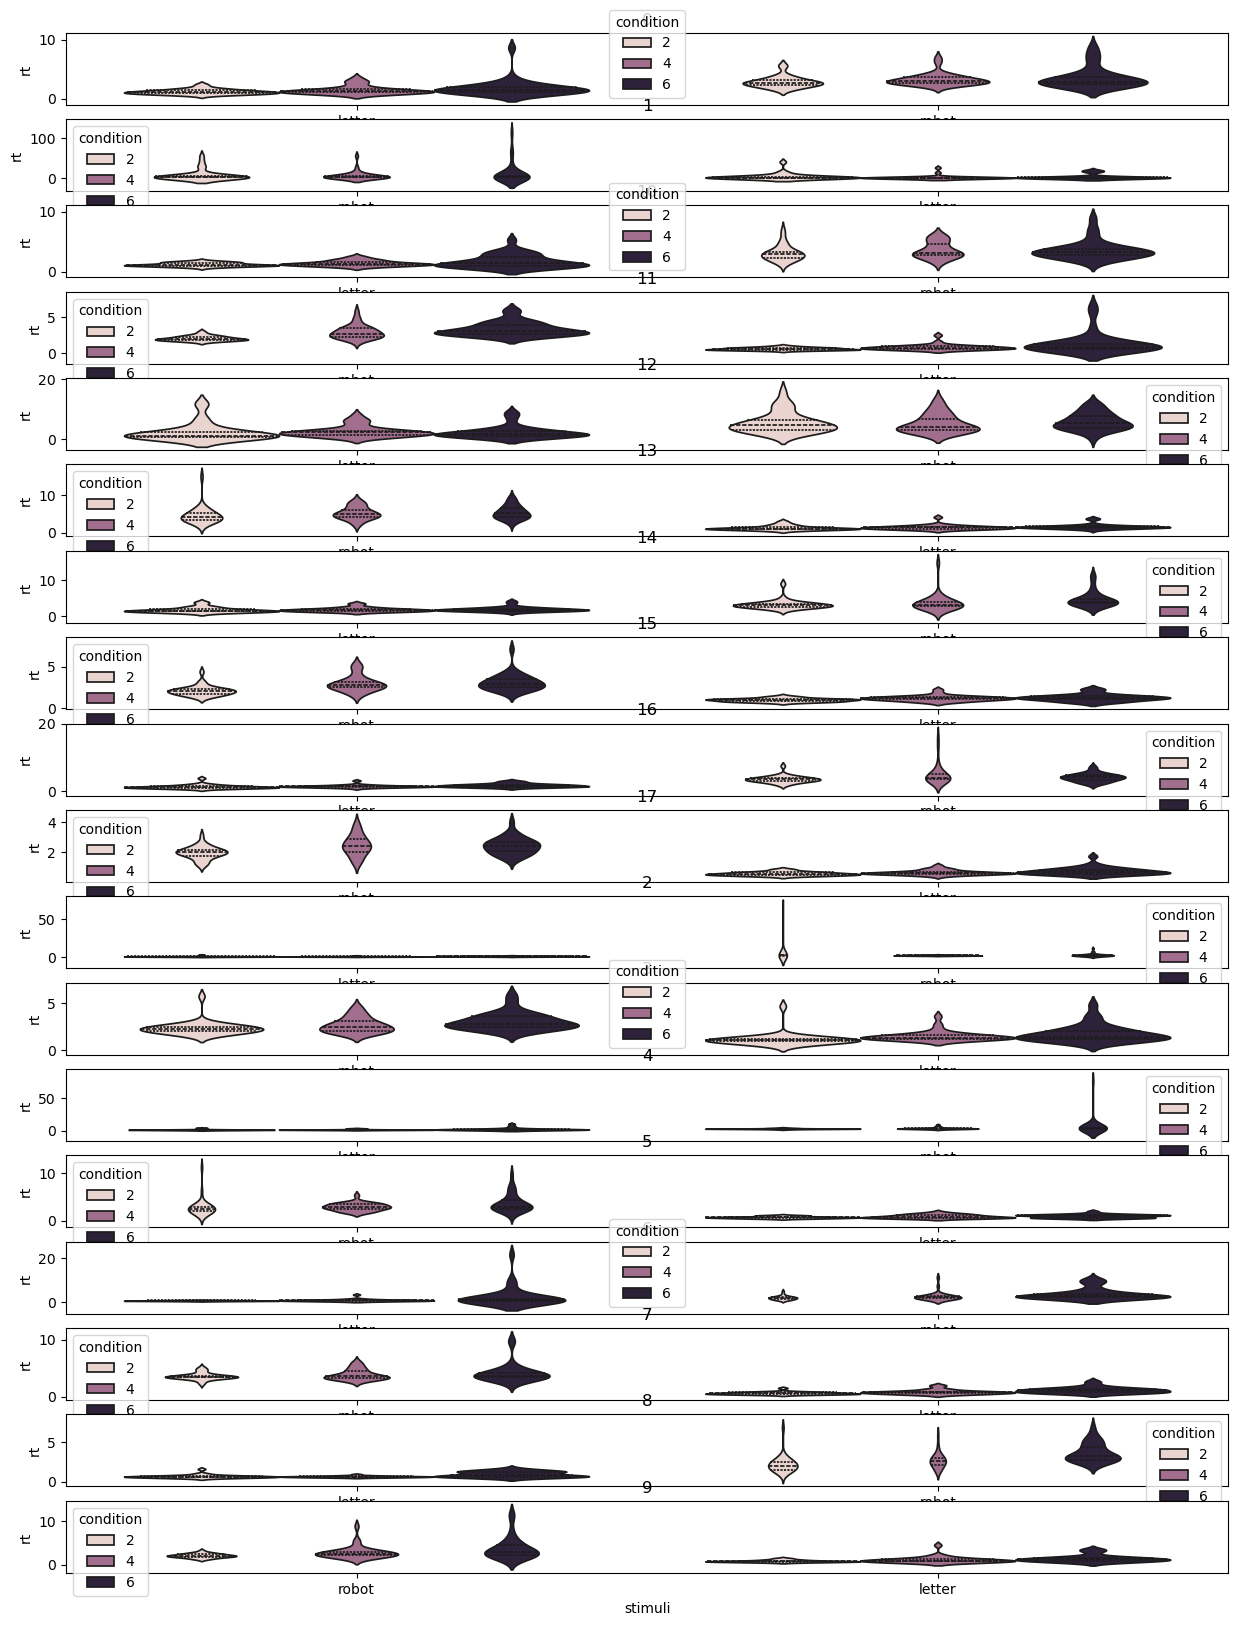

In [15]:
fig, axs = plt.subplots(len(main_result_df['subject'].unique()), figsize = (15,20))

for j, subject in enumerate(main_result_df['subject'].unique()):
    subject_df = main_result_df[main_result_df['subject']==subject]
    ax = axs[j]
    sns.violinplot(data=subject_df, x='stimuli', y='rt', hue='condition',inner='quart', ax=ax)
    ax.set_title(f'{subject}')

plt.show()

## RSME

In [15]:
iv = ['subject','stimuli','condition']
dv = 'rsme'

rsme_df = main_result_df[main_result_df[dv]!='None'].copy()
rsme_df['rsme'] = rsme_df['rsme'].astype(float)

rsme_df[iv+[dv]]

,subject,stimuli,condition,rsme
27,0,letter,6,39.104938
37,0,letter,4,30.925926
47,0,letter,2,29.537037
57,0,robot,2,33.858025
67,0,robot,4,38.796296
...,...,...,...,...
1741,8,letter,4,26.141975
1751,8,letter,6,33.703704
1761,8,robot,6,84.012346
1771,8,robot,2,36.018519


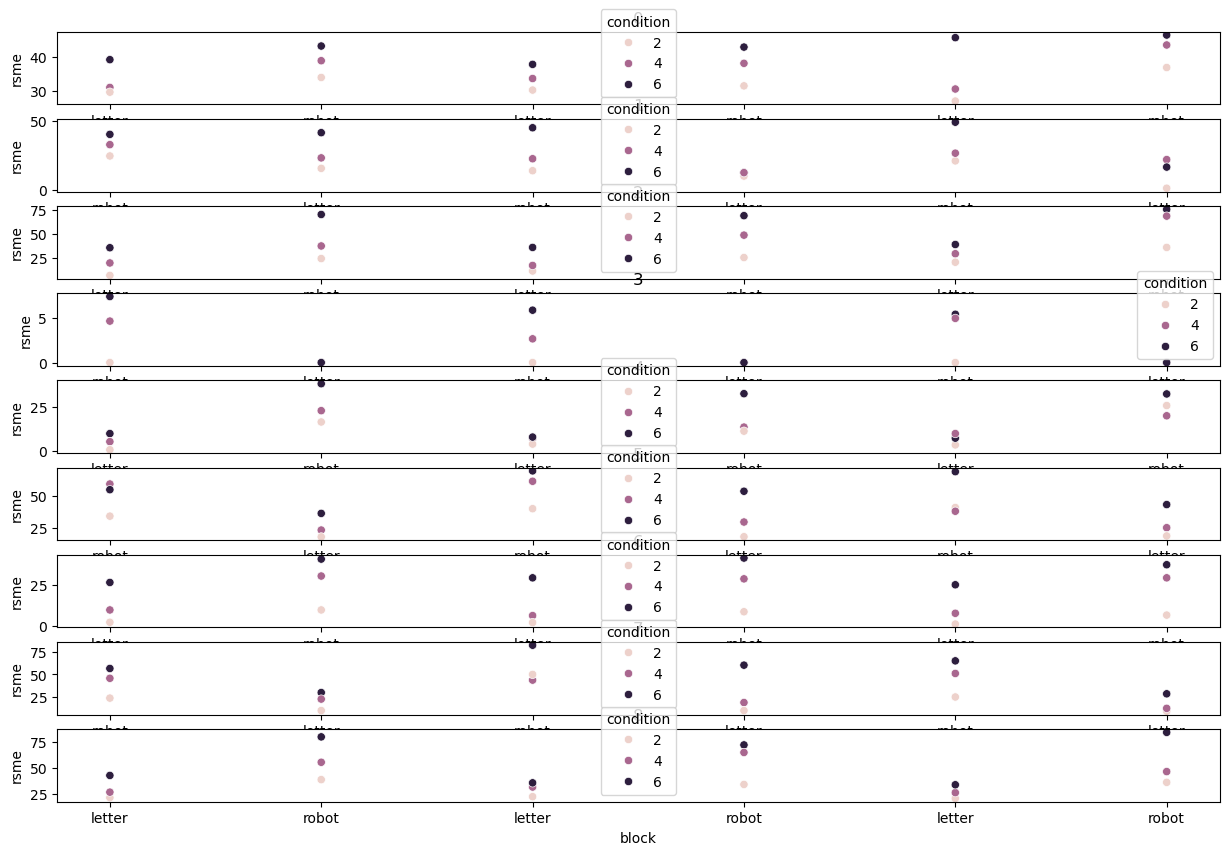

In [16]:
fig, axs = plt.subplots(len(main_result_df['subject'].unique()), figsize = (15,10))

for j, subject in enumerate(main_result_df['subject'].unique()):
    subject_df = rsme_df[rsme_df['subject']==subject]
    ax = axs[j]
    sns.scatterplot(data=subject_df, x='block', y='rsme', hue='condition', ax=ax)
    ax.set_title(f'{subject}')

    block_order = subject_df[['block','stimuli']].apply(tuple, axis=1).unique()
    ax.set_xticks([elem[0] for elem in block_order], [elem[1] for elem in block_order])

plt.show()

# Group level

## Loading

In [5]:
all_results = []
all_match = []
for subject_dir in os.listdir(data_dir):
    result_fnames = [elem for elem in os.listdir(f'data\\{subject_dir}') if elem.split('_')[0]==subject_dir.split('_')[-1] and elem.split('.')[-1]=='csv']

    if len(result_fnames)>0:
        result_fname = result_fnames[-1]
        df = pd.read_csv(f"{data_dir}\\{subject_dir}\\{result_fname}")
        df = df[df['sequence'].apply(lambda x : isinstance(x,str))]
        df['is_training'] = df['training.thisTrialN'].notna()
        all_results.append(df)
        all_match.append(subject_dir)

print(f"Get results from {sorted([int(elem.split('_')[-1])for elem in all_match])}")

if len(all_match)>0:
    all_result_df = pd.concat(all_results).reset_index(drop=True)
    loaded_subjects = all_result_df['subject'].unique()

Get results from [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [6]:
main_result_df = all_result_df[all_result_df['is_training']==False]

column_of_interest = ['sequence', 'is_true', 'target', 'condition', 'stimuli', 'block', 'subject', 'is_training', 'trials.thisTrialN', 'recall_key.keys', 'recall_key.rt', 'RSME_ticks.response']
main_result_df = main_result_df[column_of_interest].rename(columns={'trials.thisTrialN':'trial_n', 'recall_key.keys':'keys', 'recall_key.rt':'rt', 'RSME_ticks.response':'rsme'})
main_result_df[['condition','block','subject','trial_n']] = main_result_df[['condition','block','subject','trial_n']].astype(int)
main_result_df['sequence'] == main_result_df['sequence'].apply(literal_eval)

def get_confusion(x):
    answer, is_target = x['keys'], x['is_true']

    if not isinstance(answer, str):
        return 'miss'
    elif (answer,is_target) == ('c', True): #c pressed + is_true
        return 'tp'
    elif (answer,is_target) == ('n', False): #n pressed + not is_true
        return 'tn'
    elif (answer,is_target) == ('n', True): #n pressed + is_true
        return 'fn'
    elif (answer,is_target) == ('c', False): #c pressed + not is_true
        return 'fp'

main_result_df['confusion'] = main_result_df.apply(get_confusion,axis=1)

main_result_df

,sequence,is_true,target,condition,stimuli,block,subject,is_training,trial_n,keys,rt,rsme,confusion
18,"['C', 'P', 'V', 'T', 'R', 'H']",False,Q,6,letter,1,0,False,0,n,1.117961,NaN,tn
19,"['T', 'F', 'Q', 'G', 'L', 'M']",True,G,6,letter,1,0,False,1,c,0.944512,NaN,tp
20,"['T', 'F', 'Q', 'C', 'M', 'S']",True,C,6,letter,1,0,False,2,c,1.522398,NaN,tp
21,"['S', 'L', 'N', 'J', 'V', 'G']",False,C,6,letter,1,0,False,3,n,2.042702,NaN,tn
22,"['C', 'T', 'D', 'R', 'Q', 'F']",True,C,6,letter,1,0,False,4,c,1.548754,NaN,tp
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,"['G', 'H', 'K', 'P']",False,Q,4,letter,6,9,False,175,n,0.748869,NaN,tn
4748,"['W', 'Z', 'X', 'B']",False,J,4,letter,6,9,False,176,n,0.894984,NaN,tn
4749,"['P', 'B', 'Q', 'K']",True,Q,4,letter,6,9,False,177,c,0.670664,NaN,tp
4750,"['B', 'V', 'T', 'L']",False,D,4,letter,6,9,False,178,n,1.294174,NaN,tn


## Time

In [7]:
iv1 = 'subject'
iv2 = 'stimuli'
block_start = 'block_intro_key.started'
block_start_var = 'block_intro_key.rt'
block_end = 'RSME_ticks.stopped'
block_end_var = 'RSME_ticks.response'

time_df_list = []
time_result_df = all_result_df[all_result_df['is_training']==False]
for group, subdf in time_result_df.groupby(iv1):
    time_subdf = subdf[[iv2, block_start_var, block_start]].dropna()[[iv2, block_start]].reset_index(drop=True).reset_index().rename(columns={block_start:'start'})
    time_subdf['end'] = subdf[[block_end_var, block_end]].dropna()[block_end].reset_index(drop=True)
    time_subdf['duration'] = time_subdf['end'] - time_subdf['start']
    time_subdf['subject'] = int(group)
    time_df_list.append(time_subdf)

time_df = pd.concat(time_df_list)

display(time_df.groupby(by='stimuli')['duration'].describe())
display(time_df.groupby(by='stimuli')['duration'].mean().apply(lambda x : f"{int(x/60)}min {round(x%60)}s"))

,count,mean,std,min,25%,50%,75%,max
stimuli,,,,,,,,
letter,216.0,134.512381,44.435928,74.382953,87.405830,130.497051,171.800197,346.842577
robot,216.0,226.929976,70.574300,134.518999,150.930131,218.020437,291.191753,535.857292


stimuli
letter    2min 15s
robot     3min 47s
Name: duration, dtype: object

## Outliers

In [7]:
# Using previous run, subject 10 & 20 accuracy are more than 3 std lower than other subjects (on at least on condition), respectively subject 12 rt is higher
outliers = [10, 12, 20]
clean_result = main_result_df[main_result_df['subject'].apply(lambda x : x not in outliers)].copy()

## Accuracy

In [8]:
iv = ['subject','stimuli','condition']
dv = 'confusion'

order = ['tn', 'tp', 'fp', 'fn', 'miss']

melted_accuracy_df = clean_result.groupby(by=iv, as_index=False)[dv].value_counts()
melted_accuracy_df['confusion'] = pd.Categorical(melted_accuracy_df['confusion'], categories=order)

accuracy_df = melted_accuracy_df.pivot(columns='confusion', index=iv).fillna(0).astype(int)
accuracy_df.columns = [elem[1] for elem in accuracy_df.columns]

accuracy_df = accuracy_df.reset_index()
accuracy_df.head()

,subject,stimuli,condition,tn,tp,fn,fp
0,0,letter,2,15,15,0,0
1,0,letter,4,15,15,0,0
2,0,letter,6,15,15,0,0
3,0,robot,2,15,14,1,0
4,0,robot,4,13,13,2,2


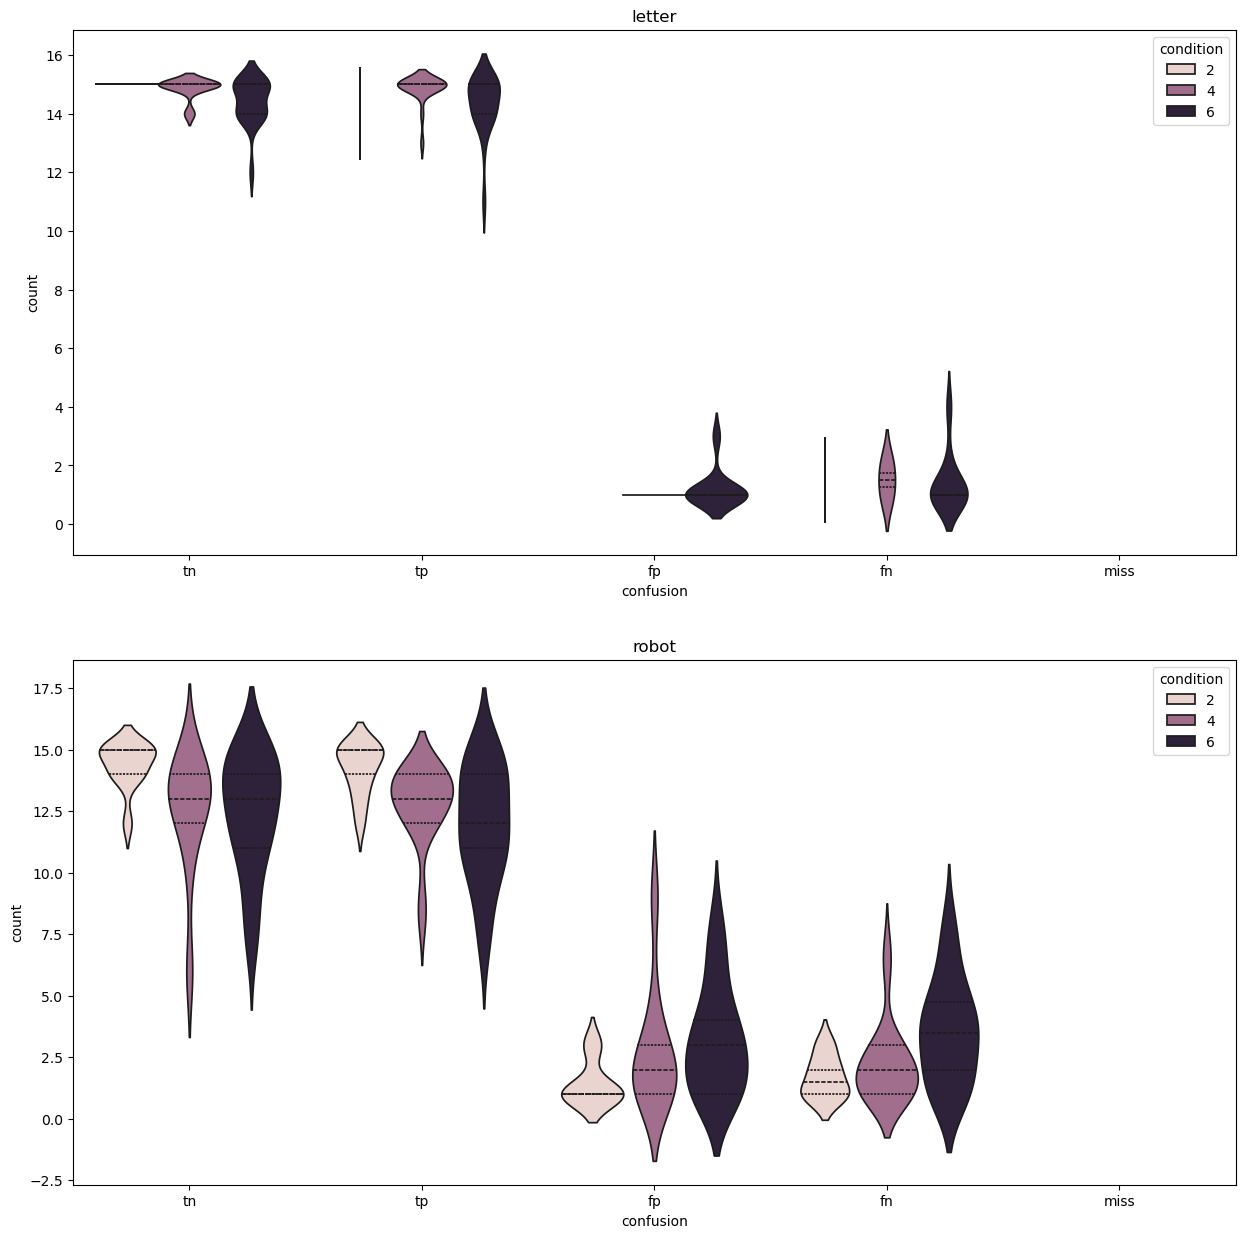

In [9]:
fig, axs = plt.subplots(2, figsize = (15,15))
for i, stimuli in enumerate(['letter', 'robot']):
        ax = axs[i]
        plot_df = melted_accuracy_df[melted_accuracy_df['stimuli']==stimuli]
        sns.violinplot(data=plot_df, x='confusion', y='count', hue='condition',inner='quart', ax=ax)
        ax.set_title(f'{stimuli}')

In [10]:
# Using combinatory metrics
accuracy_df['recall'] = accuracy_df['tp']/(accuracy_df['tp']+accuracy_df['fn'])
accuracy_df['precision'] = accuracy_df['tp']/(accuracy_df['tp']+accuracy_df['fp'])
accuracy_df['f1'] = 2*(accuracy_df['recall']*accuracy_df['precision'])/(accuracy_df['recall']+accuracy_df['precision'])

accuracy_df['correct'] = (accuracy_df['tp']+accuracy_df['tn'])/(accuracy_df['tp']+accuracy_df['tn']+accuracy_df['fp']+accuracy_df['fn'])

accuracy_df.head()

,subject,stimuli,condition,tn,tp,fn,fp,recall,precision,f1,correct
0,0,letter,2,15,15,0,0,1.000000,1.000000,1.000000,1.000000
1,0,letter,4,15,15,0,0,1.000000,1.000000,1.000000,1.000000
2,0,letter,6,15,15,0,0,1.000000,1.000000,1.000000,1.000000
3,0,robot,2,15,14,1,0,0.933333,1.000000,0.965517,0.966667
4,0,robot,4,13,13,2,2,0.866667,0.866667,0.866667,0.866667


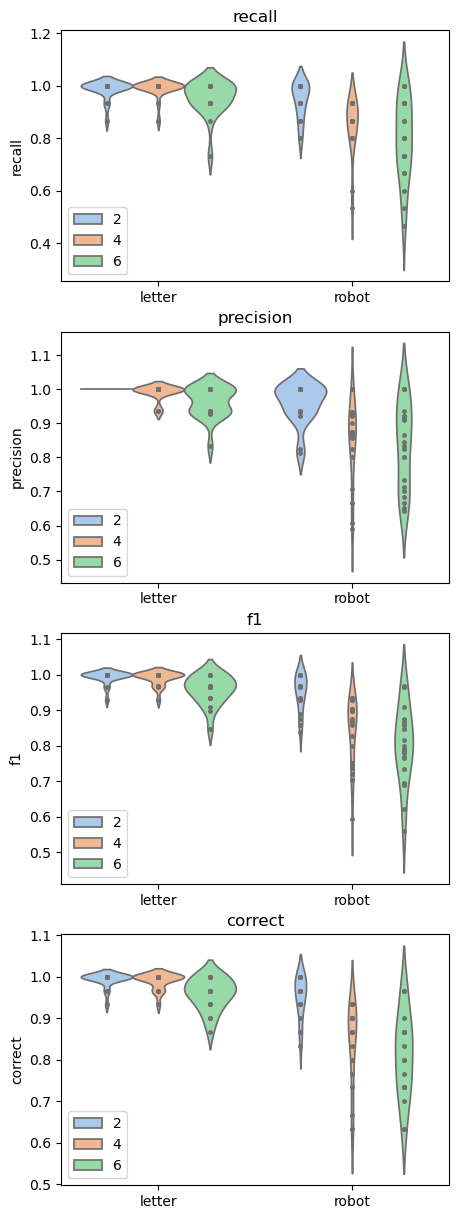

In [11]:
metrics = ['recall', 'precision', 'f1', 'correct']
fig, axs = plt.subplots(len(metrics), figsize = (5,15))

subject = None
data = accuracy_df

for i, metric in enumerate(metrics):
        ax = axs[i]

        sns.violinplot(data=data, x='stimuli', y=metric, hue='condition',inner='point', ax=ax, palette='pastel')
        handles, labels = ax.get_legend_handles_labels()

        if subject != None:
                subject_df = data[data['subject']==subject]
                sns.violinplot(data=subject_df, x='stimuli', y=metric, hue='condition', inner='point',ax=ax)
        
        ax.legend(handles, labels)
        ax.set_title(f'{metric}')
        ax.set_xlabel('')

c:\Users\ma.rihet\.conda\envs\epiic\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
c:\Users\ma.rihet\.conda\envs\epiic\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


stimuli  condition
letter   2            0.993315
         4            0.990348
         6            0.958008
robot    2            0.951693
         4            0.844048
         6            0.805287
Name: f1, dtype: float64

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,stimuli,0.406131,1,20,0.406131,72.947411,4.180917e-08,4.180917e-08,0.784825,1.000000
1,condition,0.176084,2,40,0.088042,33.107502,3.292172e-09,1.011959e-08,0.623405,0.931484
2,stimuli * condition,0.081697,2,40,0.040848,13.365458,3.586396e-05,7.350150e-05,0.400578,0.904295


c:\Users\ma.rihet\.conda\envs\epiic\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
c:\Users\ma.rihet\.conda\envs\epiic\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


stimuli  condition
letter   2            0.993651
         4            0.990476
         6            0.958730
robot    2            0.952381
         4            0.841270
         6            0.811111
Name: correct, dtype: float64

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,stimuli,0.400079,1,20,0.400079,71.000000,5.180454e-08,5.180454e-08,0.780220,1.000000
1,condition,0.167778,2,40,0.083889,37.131148,7.640838e-10,1.221758e-09,0.649928,0.973638
2,stimuli * condition,0.080370,2,40,0.040185,14.965517,1.405403e-05,3.208045e-05,0.428008,0.901465


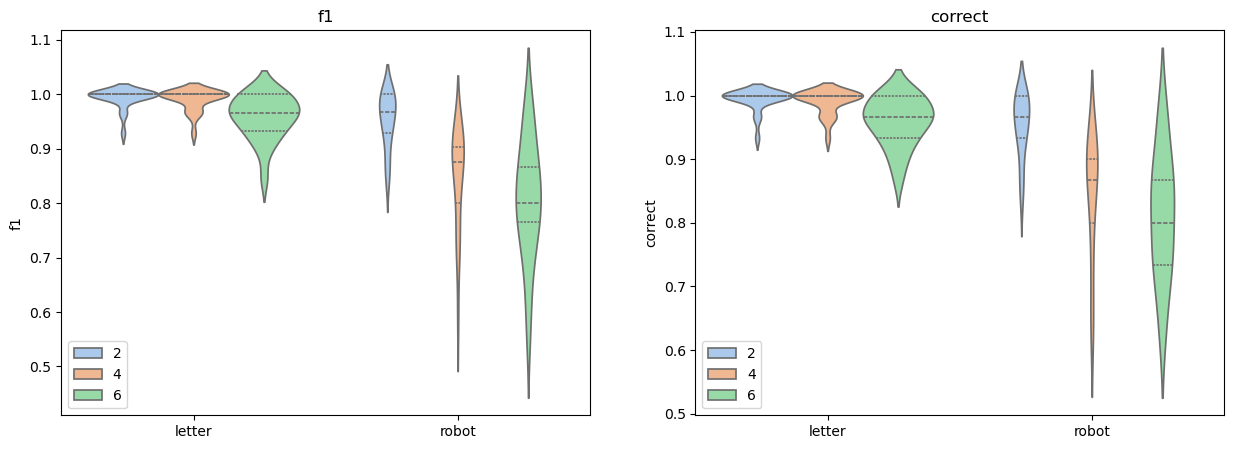

In [12]:
iv = ['stimuli', 'condition']
metrics = ['f1', 'correct']
fig, axs = plt.subplots(1, 2, figsize = (15,5))

subject = None
data = accuracy_df
stats=True

for i in range(2):
        ax = axs[i]
        metric = metrics[i]

        if stats:
                stat_df = pg.rm_anova(dv=metric, within=iv, subject='subject', data=data, detailed=True, effsize='np2')
                display(data.groupby(by=iv)[metric].mean())
                display(stat_df)

        sns.violinplot(data=data, x=iv[0], y=metric, hue=iv[1],inner='quarter', ax=ax, palette='pastel')
        handles, labels = ax.get_legend_handles_labels()

        if subject != None:
                subject_df = data[data['subject']==subject]
                sns.violinplot(data=subject_df, x=iv[0], y=metric, hue=iv[1], inner='point',ax=ax)

        ax.legend(handles, labels)
        ax.set_title(f'{metric}')
        ax.set_xlabel('')

plt.show()

In [13]:
metric = 'correct'
data = accuracy_df

z_df = zscore_by_condition(data, metric, ['stimuli', 'condition'])
z_df[z_df[f'z_{metric}']>3]

,subject,stimuli,condition,tn,tp,fn,fp,recall,precision,f1,correct,z_correct
120,23,letter,2,15,13,2,0,0.866667,1.0,0.928571,0.933333,3.535840
67,13,letter,4,15,13,2,0,0.866667,1.0,0.928571,0.933333,3.057883


## Response Time

In [14]:
clean_result['z_rt'] = get_zscore(clean_result['rt'])
clean_result['abs_z_rt'] = clean_result['z_rt'].apply(abs)

In [15]:
clean_result[clean_result['abs_z_rt']>3]['subject'].value_counts()

subject
1     20
13     1
14     1
16     1
2      1
4      1
6      1
Name: count, dtype: int64

In [16]:
iv = ['subject','stimuli','condition']
dv = 'rt'

rt_df = clean_result.groupby(by=iv, as_index=False)[dv].mean()

rt_df.head()

,subject,stimuli,condition,rt
0,0,letter,2,1.180487
1,0,letter,4,1.469782
2,0,letter,6,1.798378
3,0,robot,2,2.835180
4,0,robot,4,3.272654


c:\Users\ma.rihet\.conda\envs\epiic\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
c:\Users\ma.rihet\.conda\envs\epiic\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


stimuli  condition
letter   2            1.112783
         4            1.205955
         6            1.593074
robot    2            3.043022
         4            3.397562
         6            4.167654
Name: rt, dtype: float64

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,stimuli,156.947401,1,20,156.947401,113.179701,1.106180e-09,1.106180e-09,0.849827,1.000000
1,condition,14.403775,2,40,7.201888,17.164237,4.150452e-06,1.804401e-05,0.461848,0.845887
2,stimuli * condition,2.205555,2,40,1.102778,3.593496,3.670742e-02,5.771645e-02,0.152309,0.670033


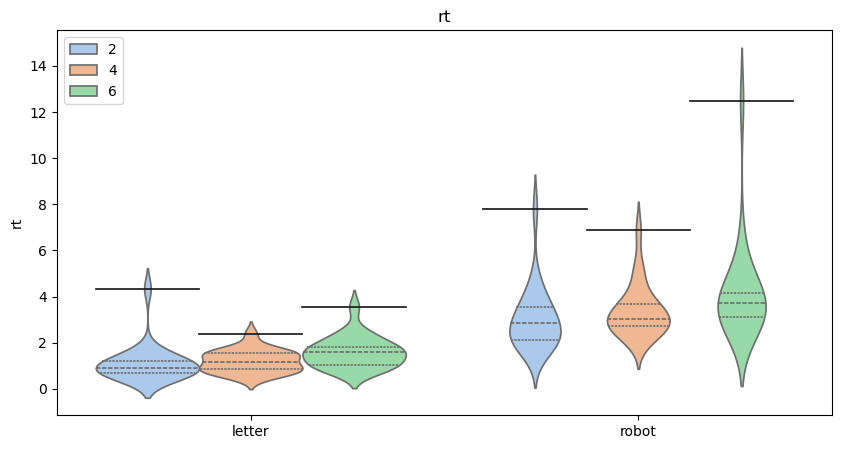

In [17]:
iv = ['stimuli', 'condition']
metrics = ['rt']
fig, axs = plt.subplots(len(metrics), figsize = (10,5))

subject = 1
data = rt_df
stat=True

for i, metric in enumerate(metrics):
        # ax = axs[i]
        ax=axs
        if stats:
                stat_df = pg.rm_anova(dv=metric, within=iv, subject='subject', data=data, detailed=True, effsize='np2')
                display(data.groupby(by=iv)[metric].mean())
                display(stat_df)

        sns.violinplot(data=data, x=iv[0], y=metric, hue=iv[1],inner='quarter', ax=ax, palette='pastel')
        handles, labels = ax.get_legend_handles_labels()

        if subject != None:
                subject_df = data[data['subject']==subject]
                sns.violinplot(data=subject_df, x=iv[0], y=metric, hue=iv[1], inner='point',ax=ax)

        ax.legend(handles, labels)
        ax.set_title(f'{metric}')
        ax.set_xlabel('')

plt.show()

In [18]:
metric = 'rt'
data = rt_df

z_df = zscore_by_condition(data, metric, ['stimuli', 'condition'])
z_df[z_df[f'z_{metric}']>3]

,subject,stimuli,condition,rt,z_rt
6,1,letter,2,4.346849,3.976321
9,1,robot,2,7.789852,3.451050
10,1,robot,4,6.880698,3.080249
11,1,robot,6,12.472157,3.902101


## Subjectif

In [19]:
iv = ['subject','stimuli','condition']
dv = 'rsme'

clean_result_subdf = clean_result[clean_result['rsme']!='None'].copy()
clean_result_subdf['rsme'] = clean_result_subdf['rsme'].astype(float)

rsme_df = clean_result_subdf.groupby(by=iv, as_index=False)[dv].mean()

rsme_df.head()

,subject,stimuli,condition,rsme
0,0,letter,2,28.868313
1,0,letter,4,31.646091
2,0,letter,6,40.802469
3,0,robot,2,34.012346
4,0,robot,4,40.082305


c:\Users\ma.rihet\.conda\envs\epiic\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
c:\Users\ma.rihet\.conda\envs\epiic\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


stimuli  condition
letter   2            14.241623
         4            23.956496
         6            36.566725
robot    2            30.170978
         4            44.437586
         6            56.435430
Name: rsme, dtype: float64

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,stimuli,11085.699347,1,20,11085.699347,71.049653,5.151920e-08,5.151920e-08,0.780340,1.000000
1,condition,12395.647654,2,40,6197.823827,102.015541,1.960184e-16,2.722087e-10,0.836086,0.569256
2,stimuli * condition,128.141208,2,40,64.070604,2.994289,6.140453e-02,6.501461e-02,0.130219,0.941530


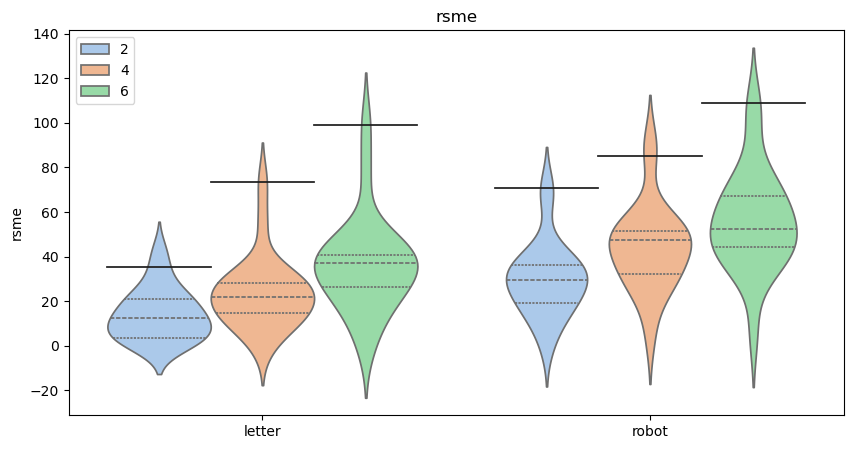

In [20]:
iv = ['stimuli', 'condition']
metrics = ['rsme']
fig, axs = plt.subplots(len(metrics), figsize = (10,5))

subject = 21
data = rsme_df
stat = True

for i, metric in enumerate(metrics):
        # ax = axs[i]
        ax=axs
        if stats:
                stat_df = pg.rm_anova(dv=metric, within=iv, subject='subject', data=data, detailed=True, effsize='np2')
                display(data.groupby(by=iv)[metric].mean())
                display(stat_df)

        sns.violinplot(data=data, x=iv[0], y=metric, hue=iv[1],inner='quarter', ax=ax, palette='pastel')
        handles, labels = ax.get_legend_handles_labels()

        if subject != None:
                subject_df = data[data['subject']==subject]
                sns.violinplot(data=subject_df, x=iv[0], y=metric, hue=iv[1], inner='point',ax=ax)

        ax.legend(handles, labels)
        ax.set_title(f'{metric}')
        ax.set_xlabel('')

plt.show()

In [21]:
metric = 'rsme'
data = rsme_df

z_df = zscore_by_condition(data, metric, ['stimuli', 'condition'])
z_df[z_df[f'z_{metric}']>3]

,subject,stimuli,condition,rsme,z_rsme
109,21,letter,4,73.518519,3.056999


## All results

In [22]:
iv = ['subject', 'stimuli', 'condition']
metrics = ['correct', 'f1', 'rt', 'rsme']
result_df = accuracy_df.merge(rt_df, left_on=iv, right_on=iv).merge(rsme_df, left_on=iv, right_on=iv)
result_df = result_df[iv + metrics]

result_df

,subject,stimuli,condition,correct,f1,rt,rsme
0,0,letter,2,1.000000,1.000000,1.180487,28.868313
1,0,letter,4,1.000000,1.000000,1.469782,31.646091
2,0,letter,6,1.000000,1.000000,1.798378,40.802469
3,0,robot,2,0.966667,0.965517,2.835180,34.012346
4,0,robot,4,0.866667,0.866667,3.272654,40.082305
...,...,...,...,...,...,...,...
121,23,letter,4,0.966667,0.967742,0.505593,32.417695
122,23,letter,6,0.933333,0.933333,0.806455,44.917695
123,23,robot,2,1.000000,1.000000,1.547331,12.664609
124,23,robot,4,0.933333,0.933333,2.095777,32.520576


In [23]:
result_df.to_csv("sternberg_results.csv", index=False)